# library

In [1]:
import os
import sys
import re
import pickle
import random
import subprocess
import time
import threading
import shutil
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, wait, ALL_COMPLETED, as_completed
from datetime import datetime, timedelta
from multiprocessing import Process, Pool

import numpy as np
import pandas as pd
import anndata as ad
import h5py
# import Bio
# from Bio import motifs
# import pysam
import pyranges
import pybedtools
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn import preprocessing
import scipy
from scipy import io
import scanpy as sc
from sklearn.cluster import KMeans
# from adjustText import adjust_text
# import episcanpy
import ruamel.yaml
yaml = ruamel.yaml.YAML(typ="safe")
yaml.default_flow_style = False
from matplotlib_venn import venn3, venn2, venn3_unweighted, venn2_unweighted

import SCRIP
from SCRIP.utilities import utils
from SCRIP.utilities.utils import print_log, safe_makedirs, excute_info, read_pickle, read_SingleCellExperiment_rds, store_to_pickle

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
# warnings.simplefilter(action='ignore', category=subprocess.)

plt.rcParams.update({
    'figure.figsize': [8.0, 8.0],
    'font.size' : 15,
    'font.family': 'Arial',
    'font.style' : 'normal',
    'font.weight':'normal',
    'figure.titleweight': 'normal',
    'axes.labelsize': 14 ,
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'axes.spines.right': False,
    'axes.spines.top': False,
})

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(220/256, 34/256, N)
vals[:, 1] = np.linspace(220/256, 7/256, N)
vals[:, 2] = np.linspace(220/256, 141/256, N)
regulation_cmp = mpl.colors.ListedColormap(vals)

In [2]:
import anndata2ri

In [ ]:
atac = read_SingleCellExperiment_rds('example/PBMC/data/PBMC_ATAC_500bin/analysis/PBMC_TBMono_500bin.rds')
atac.var.index = [i.replace('-', '_') for i in atac.var.index]
impute_factor = 'H3K27ac'


atac.obs['nFeature_ATAC'] = atac.obs['nFeature_ATAC'].astype(int)
atac.obs['nCount_ATAC'] = atac.obs['nCount_ATAC'].astype(int)

In [11]:
atac.write_h5ad('example/PBMC/data/PBMC_ATAC_500bin/analysis/PBMC_TBMono_500bin.h5ad')

/fs/home/dongxin/Applications/miniconda3/envs/SCRIPT/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Celltype' as categorical


In [14]:
atac = ad.read_h5ad('example/PBMC/data/PBMC_ATAC_500bin/analysis/PBMC_TBMono_500bin.h5ad')

In [15]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)
sc.pp.filter_genes(atac, min_cells=50)

In [41]:
atac.write_h5ad('example/PBMC/data/PBMC_ATAC_500bin/analysis/PBMC_TBMono_500bin_passQC.h5ad')

In [ ]:
chip_cell_peak_H3K27ac, factor_score = impute(atac, 'H3K27ac', '/fs/home/dongxin/Projects/SCRIPT/indices/index/HM_human', 
                                              bed_check=True, search_check=True, path='example/histone/peak_base/cuttagpro/SCRIP_PBMC/imputationPBMC0613_not_remove/', 
                                              write_format='h5ad', ref_baseline=500, remove_others_source=False, n_cores=64)

In [41]:
chip_cell_peak_H3K27ac.write_h5ad('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/peak_base/cuttagpro/SCRIP_PBMC/imputationPBMC0612/H3K27ac/imputed_H3K27ac.h5ad')

In [55]:
write_to_mtx(chip_cell_peak_H3K27ac, 'example/histone/peak_base/cuttagpro/SCRIP_PBMC/imputationPBMC0613_not_remove/H3K27ac/imputed_H3K27ac_mtx')

In [ ]:
sc.pp.filter_genes(chip_cell_peak_H3K27ac, min_cells=20)

## Plot

In [2]:
bulk_t_target = pd.read_csv('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/62350_gene_score_5fold_T.txt', comment = '#', sep='\t', header = None)
bulk_mono_target = pd.read_csv('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/34935_gene_score_5fold_Mono.txt', comment = '#', sep='\t', header = None)

bulk_t_target_list = bulk_t_target[6].unique()
bulk_mono_target_list = bulk_mono_target[6].unique()

bulk_t_target_rp = bulk_t_target.groupby(6).max()[4]
bulk_mono_target_rp = bulk_mono_target.groupby(6).max()[4]

In [3]:
impute_RP = sc.read_h5ad('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/peak_base/cuttagpro/SCRIP_PBMC/imputationPBMC0613_not_remove/imputed_H3K27ac_RP.h5ad').to_df().T
impute_RP.columns = [i.split('-')[0] for i in impute_RP.columns]
keys = pd.read_csv('example/PBMC/barcode_key.txt', sep='\t', index_col=0)
keys.index = keys['ATAC']
impute_metadata = pd.read_csv('example/PBMC/analysis/metadata.txt', sep='\t', index_col=0)

In [8]:
atac_rp = sc.read_h5ad('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/peak_base/cuttagpro/SCRIP_PBMC/imputationPBMC0613_not_remove/atac_H3K27ac_RP.h5ad').to_df().T
atac_rp.columns = [i.split('-')[0] for i in atac_rp.columns]

In [ ]:
real_RP = read_pickle('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/peak_base/cuttagpro/SCRIPT_PBMC/real_RP.pk')

In [11]:
real_matadata = pd.read_csv('example/histone/peak_base/cuttagpro/SCRIPT_PBMC/real_meta_data.txt', sep='\t')

In [ ]:
tmp_meta = pd.read_csv('example/PBMC/pbmc_meta.txt', sep='\t', index_col=0)
keys.index = keys['RNA']
tmp_meta.index = [keys.loc[i,'ATAC'] for i in tmp_meta.index]
keys.index = keys['ATAC']

# RP correlation

In [13]:
bulk_t_target = pd.read_csv('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/62350_gene_score_5fold_T.txt', comment = '#', sep='\t', header = None)
bulk_mono_target = pd.read_csv('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/34935_gene_score_5fold_Mono.txt', comment = '#', sep='\t', header = None)

bulk_t_target_list = bulk_t_target[6].unique()
bulk_mono_target_list = bulk_mono_target[6].unique()

bulk_t_target_rp = bulk_t_target.groupby(6).max()[4]
bulk_mono_target_rp = bulk_mono_target.groupby(6).max()[4]

In [16]:
bulk_ovlp_target = set(bulk_t_target_rp.index).intersection(impute_t_rp.index)

In [15]:
# impute_t_bc = tmp_meta.index[(tmp_meta['CellType'] == 'naive_CD4_T_cells') | (tmp_meta['CellType'] == 'memory_CD4_T_cells') | (tmp_meta['CellType'] == 'naive_CD8_T_cells')| (tmp_meta['CellType'] == 'effector_CD8_T_cells')]
with open('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/peak_base/cuttagpro/SCRIP_PBMC/impute_t_bc.txt','r') as file:
    impute_t_bc = [i.rstrip().split('-')[0] for i in file.readlines()]
# impute_t_bc = set(impute_RP.columns).intersection(keys.loc[impute_t_bc,'RNA'])
impute_t_bc = set(impute_RP.columns).intersection(impute_t_bc)
impute_t_rp = impute_RP[impute_t_bc].max(1)

atac_t_rp = atac_rp[impute_t_bc].max(1)

real_t_bc = real_matadata.index[(real_matadata['Celltype'] == 'CD4 T') | (real_matadata['Celltype'] == 'CD8 T') | (real_matadata['Celltype'] == 'other T')]
# real_t_bc = real_matadata.index[ (real_matadata['Celltype'] == 'CD4 T')]
real_t_rp = real_RP[real_t_bc].max(1)

In [19]:
scipy.stats.spearmanr(impute_t_rp,real_t_rp)

SpearmanrResult(correlation=0.6826890470656624, pvalue=0.0)

In [20]:
scipy.stats.spearmanr(atac_t_rp,real_t_rp)

SpearmanrResult(correlation=0.5583129203614595, pvalue=0.0)

In [21]:
scipy.stats.spearmanr(real_t_rp[bulk_ovlp_target],bulk_t_target_rp[bulk_ovlp_target])

SpearmanrResult(correlation=0.3856955331547345, pvalue=0.0)

In [22]:
# impute_mono_bc = tmp_meta.index[(tmp_meta['CellType'] == 'non-classical_monocytes') | (tmp_meta['CellType'] == 'classical_monocytes') | (tmp_meta['CellType'] == 'intermediate_monocytes')]
with open('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/peak_base/cuttagpro/SCRIP_PBMC/impute_mono_bc.txt','r') as file:
    impute_mono_bc = [i.rstrip().split('-')[0] for i in file.readlines()]
# impute_mono_bc = set(impute_RP.columns).intersection(keys.loc[impute_mono_bc,'RNA'])
impute_mono_bc = set(impute_RP.columns).intersection(impute_mono_bc)
impute_mono_rp = impute_RP[impute_mono_bc].max(1)

atac_mono_rp = atac_rp[impute_mono_bc].max(1)

real_mono_bc = real_matadata.index[(real_matadata['Celltype'] == 'Mono')]
real_mono_rp = real_RP[real_mono_bc].max(1)

In [23]:
scipy.stats.spearmanr(impute_mono_rp,real_mono_rp)

SpearmanrResult(correlation=0.7298391431790926, pvalue=0.0)

In [24]:
scipy.stats.spearmanr(atac_mono_rp,real_mono_rp)

SpearmanrResult(correlation=0.6316547474096083, pvalue=0.0)

In [25]:
scipy.stats.spearmanr(real_mono_rp[bulk_ovlp_target],bulk_t_target_rp[bulk_ovlp_target])

SpearmanrResult(correlation=0.3584068064358755, pvalue=0.0)

In [27]:
data_df = pd.DataFrame([['SCRIP Imputed', 'T Cells', 0.6826890470656624], ['SCRIP Imputed', 'Monocytes', 0.7298391431790926], 
                        ['scATAC-seq', 'T Cells', 0.5583129203614595], ['scATAC-seq', 'Monocytes', 0.6316547474096083], 
                        ['Bulk', 'T Cells', 0.3856955331547345], ['Bulk', 'Monocytes', 0.3584068064358755]])

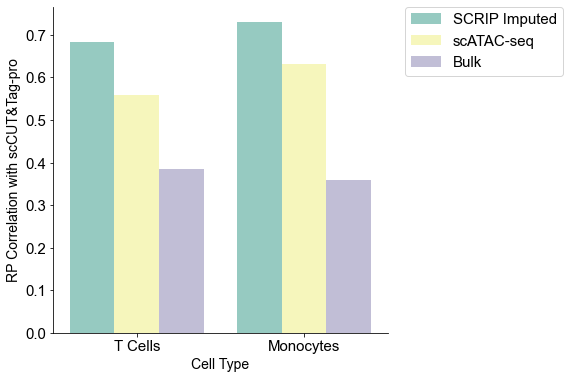

In [28]:
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x=1, y=2, data=data_df, hue=0, palette='Set3', ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set_xlabel('Cell Type')
ax.set_ylabel('RP Correlation with scCUT&Tag-pro')
fig.show()
fig.savefig('Figures/RP_correlation_imputed_atac_bulk.pdf', bbox_inches='tight')

# target venn overlap

In [29]:
with open('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/peak_base/cuttagpro/SCRIP_PBMC/impute_t_bc.txt','r') as file:
    impute_t_bc = [i.rstrip().split('-')[0] for i in file.readlines()]
impute_t_bc = set(impute_RP.columns).intersection(impute_t_bc)
impute_t_rp = impute_RP[impute_t_bc].mean(1)

atac_t_rp = atac_rp[impute_t_bc].mean(1)

real_t_bc = real_matadata.index[(real_matadata['Celltype'] == 'CD4 T') | (real_matadata['Celltype'] == 'CD8 T') | (real_matadata['Celltype'] == 'other T')]
real_t_rp = real_RP[real_t_bc].mean(1)

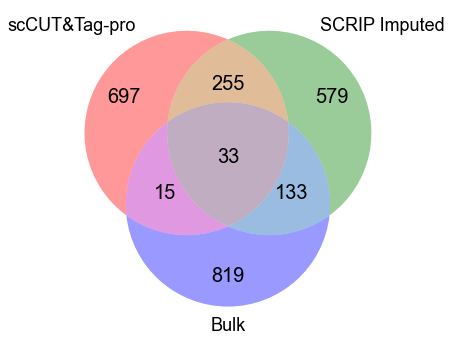

In [252]:
set1 = set(real_t_rp[bulk_ovlp_target].sort_values(ascending=False)[0:1000].index)
set2 = set(impute_t_rp[bulk_ovlp_target].sort_values(ascending=False)[0:1000].index)
set3 = set(bulk_t_target_list[0:1000])

fig, ax = plt.subplots(figsize=(6,6))
out = venn3_unweighted([set1, set2, set3],  ('scCUT&Tag-pro', 'SCRIP Imputed', 'Bulk'))
# out = venn3_unweighted([736, 637, 232, 858, 11, 110, 21],  ('scCUT&Tag-pro', 'SCRIP Imputed', 'Bulk'))
for x in range(len(out.subset_labels)):
    if out.subset_labels[x] is not None:
        out.subset_labels[x].set_fontsize(20)
fig.show()
fig.savefig('Figures/T_target_venn.pdf')

In [48]:
# This is used to perform the go analysis
for i in impute_t_rp[bulk_ovlp_target].sort_values(ascending=False)[0:300].index:
    print(i, end='", "')

PER1", "JUNB", "ZFP36", "VAMP2", "CIRBP", "MIDN", "KDM6B", "PLEKHG2", "CIC", "FOSB", "JUND", "TMEM107", "ERF", "FAM174C", "TEDC1", "KLF16", "MNT", "ARHGAP45", "BORCS6", "H3C4", "H2AC7", "MAZ", "H2BC7", "CRIP1", "ING1", "PHF23", "TSEN34", "U2AF2", "MBOAT7", "GABARAP", "RPS11", "AKT1S1", "HNRNPL", "DUSP1", "H4C5", "ATP5F1D", "TBC1D17", "DBP", "CUTA", "H4C2", "GSK3A", "TMEM88", "ZNF48", "H3C2", "UBE2M", "CCDC106", "HOOK2", "WDR74", "SYNGAP1", "TRIM41", "PLEC", "ERCC1", "SIN3A", "H2AC4", "PRRT2", "PHF1", "ZNF581", "DVL2", "FBRS", "RPL13A", "MYLPF", "ZNF580", "NAA38", "TBC1D10B", "CHMP2A", "CYB5D1", "DNAJB1", "H4C1", "MZF1", "MEPCE", "FKBP2", "PTMA", "PAGR1", "LOC114841035", "FLT3LG", "PNKP", "TCTEX1D4", "U2AF1L4", "PSENEN", "BTBD19", "ZCWPW1", "POLR2E", "PRDX2", "H2BC8", "ADGRE5", "H2AC8", "H4C4", "ZNRD2", "MED29", "CCDC85B", "EIF5A", "PAF1", "UBTF", "CD248", "RPLP2", "FIBP", "CTDNEP1", "ELP5", "H3C1", "RNPEPL1", "ATXN7L3", "FAM89B", "MUS81", "ABHD17A", "C12orf57", "SCO2", "PLK3", "SARAF",

In [33]:
with open('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/peak_base/cuttagpro/SCRIP_PBMC/impute_mono_bc.txt','r') as file:
    impute_mono_bc = [i.rstrip().split('-')[0] for i in file.readlines()]
impute_mono_bc = set(impute_RP.columns).intersection(impute_mono_bc)
impute_mono_rp = impute_RP[impute_mono_bc].mean(1)

atac_mono_rp = atac_rp[impute_mono_bc].mean(1)

real_mono_bc = real_matadata.index[(real_matadata['Celltype'] == 'Mono')]
real_mono_rp = real_RP[real_mono_bc].mean(1)

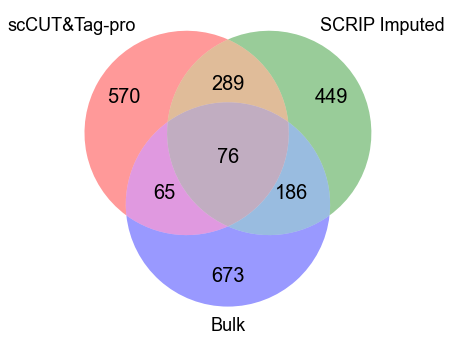

In [35]:
set1 = set(real_mono_rp[bulk_ovlp_target].sort_values(ascending=False)[0:1000].index)
set2 = set(impute_mono_rp[bulk_ovlp_target].sort_values(ascending=False)[0:1000].index)
set3 = set(bulk_mono_target_list[0:1000])

fig, ax = plt.subplots(figsize=(6,6))
out = venn3_unweighted([set1, set2, set3],  ('scCUT&Tag-pro', 'SCRIP Imputed', 'Bulk'))
# out = venn3_unweighted([661, 545, 232, 702, 75, 191, 32], ('scCUT&Pro', 'SCRIPT Imputed', 'Bulk'))
for x in range(len(out.subset_labels)):
    if out.subset_labels[x] is not None:
        out.subset_labels[x].set_fontsize(20)
fig.show()
fig.savefig('Figures/mono_target_venn.pdf')

In [49]:
for i in impute_mono_rp[bulk_ovlp_target].sort_values(ascending=False)[0:300].index:
    print(i, end='", "')

ZFP36", "PLEKHG2", "KDM6B", "ODF3B", "TYMP", "MIDN", "SCO2", "ERCC1", "JUNB", "DUSP1", "FOSB", "CIRBP", "PER1", "TSEN34", "MED29", "MBOAT7", "PAF1", "MNT", "JUND", "FOS", "RPS9", "TMEM88", "MYADM", "BTBD19", "TCTEX1D4", "ATP5F1D", "VAMP2", "UBE2M", "LRRFIP1", "MZF1", "AKT1S1", "NAA38", "TBC1D17", "CYB5D1", "CTDSP1", "FTH1", "IFI30", "CIC", "FAM174C", "CHMP2A", "TEDC1", "EIF4A1", "WDR74", "IRF1", "FKBP2", "LOC114841035", "CRIP1", "OSM", "VIM", "KLF16", "KLF2", "GABARAP", "CD68", "SSBP4", "PHF23", "PLK3", "NANOS3", "FBRS", "TMEM107", "ESRRA", "ING1", "CBARP", "THEMIS2", "FOXO3", "SOCS3", "PNKP", "PNPLA2", "BORCS6", "KLHDC7B", "GPX4", "STX5", "ERF", "USP3", "RPS16", "HNRNPL", "PTMA", "BRD2", "LOC100996842", "NR4A1", "MPDU1", "CTDNEP1", "ELP5", "PLAUR", "ADGRE5", "ATF3", "CD74", "RARA", "CDK9", "PPP1R14B", "RPLP2", "IQCN", "CATSPERZ", "PRR14", "U2AF2", "SP1", "FOSL2", "CCDC9", "H3-3B", "NR1D1", "U2AF1L4", "PSENEN", "MKNK2", "SH2D3C", "PDE4A", "DBP", "POLR2E", "ATP6V0C", "AMDHD2", "DVL2", "